# cGAN으로 생성 제어하기

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

In [4]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [5]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [6]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

이폭 [0/300] d_loss:0.3160 g_loss: 6.8871 D(x):0.89 D(G(z)):0.04
이폭 [1/300] d_loss:0.5910 g_loss: 3.9762 D(x):0.87 D(G(z)):0.19
이폭 [2/300] d_loss:0.3091 g_loss: 4.8783 D(x):0.92 D(G(z)):0.08
이폭 [3/300] d_loss:0.1595 g_loss: 4.3155 D(x):0.95 D(G(z)):0.06
이폭 [4/300] d_loss:0.5849 g_loss: 3.0070 D(x):0.78 D(G(z)):0.13
이폭 [5/300] d_loss:0.4532 g_loss: 3.0106 D(x):0.82 D(G(z)):0.10
이폭 [6/300] d_loss:1.0214 g_loss: 2.8349 D(x):0.64 D(G(z)):0.09
이폭 [7/300] d_loss:0.6247 g_loss: 2.1058 D(x):0.79 D(G(z)):0.20
이폭 [8/300] d_loss:0.6507 g_loss: 1.7656 D(x):0.82 D(G(z)):0.27
이폭 [9/300] d_loss:0.6669 g_loss: 1.7414 D(x):0.81 D(G(z)):0.25
이폭 [10/300] d_loss:0.6982 g_loss: 2.1408 D(x):0.81 D(G(z)):0.26
이폭 [11/300] d_loss:0.8622 g_loss: 1.8217 D(x):0.74 D(G(z)):0.25
이폭 [12/300] d_loss:0.8173 g_loss: 2.0123 D(x):0.77 D(G(z)):0.26
이폭 [13/300] d_loss:0.7775 g_loss: 1.7512 D(x):0.75 D(G(z)):0.28
이폭 [14/300] d_loss:0.7232 g_loss: 1.5495 D(x):0.76 D(G(z)):0.27
이폭 [15/300] d_loss:0.8877 g_loss: 1.4896 D(x):0.69

이폭 [128/300] d_loss:1.1599 g_loss: 1.0357 D(x):0.60 D(G(z)):0.39
이폭 [129/300] d_loss:1.2836 g_loss: 0.9070 D(x):0.55 D(G(z)):0.43
이폭 [130/300] d_loss:1.3021 g_loss: 1.0356 D(x):0.58 D(G(z)):0.41
이폭 [131/300] d_loss:1.0849 g_loss: 1.2057 D(x):0.59 D(G(z)):0.35
이폭 [132/300] d_loss:1.1975 g_loss: 0.9894 D(x):0.54 D(G(z)):0.39
이폭 [133/300] d_loss:1.2037 g_loss: 1.0071 D(x):0.56 D(G(z)):0.40
이폭 [134/300] d_loss:1.3586 g_loss: 0.7803 D(x):0.55 D(G(z)):0.48
이폭 [135/300] d_loss:1.0960 g_loss: 1.3504 D(x):0.56 D(G(z)):0.29
이폭 [136/300] d_loss:1.2298 g_loss: 0.9643 D(x):0.62 D(G(z)):0.42
이폭 [137/300] d_loss:1.1276 g_loss: 1.0070 D(x):0.62 D(G(z)):0.41
이폭 [138/300] d_loss:1.0824 g_loss: 1.0769 D(x):0.63 D(G(z)):0.40
이폭 [139/300] d_loss:1.0641 g_loss: 1.1952 D(x):0.64 D(G(z)):0.39
이폭 [140/300] d_loss:1.3613 g_loss: 0.9529 D(x):0.52 D(G(z)):0.45
이폭 [141/300] d_loss:1.2217 g_loss: 1.0125 D(x):0.62 D(G(z)):0.42
이폭 [142/300] d_loss:1.2494 g_loss: 0.8275 D(x):0.58 D(G(z)):0.46
이폭 [143/300] d_loss:1.168

이폭 [255/300] d_loss:1.3796 g_loss: 0.8272 D(x):0.57 D(G(z)):0.47
이폭 [256/300] d_loss:1.3426 g_loss: 0.9632 D(x):0.52 D(G(z)):0.42
이폭 [257/300] d_loss:1.2546 g_loss: 1.0157 D(x):0.57 D(G(z)):0.42
이폭 [258/300] d_loss:1.2047 g_loss: 0.9986 D(x):0.62 D(G(z)):0.44
이폭 [259/300] d_loss:1.3171 g_loss: 1.0010 D(x):0.54 D(G(z)):0.40
이폭 [260/300] d_loss:1.3425 g_loss: 0.8781 D(x):0.55 D(G(z)):0.46
이폭 [261/300] d_loss:1.2267 g_loss: 1.0366 D(x):0.62 D(G(z)):0.44
이폭 [262/300] d_loss:1.1505 g_loss: 1.1203 D(x):0.61 D(G(z)):0.39
이폭 [263/300] d_loss:1.2370 g_loss: 0.9579 D(x):0.57 D(G(z)):0.44
이폭 [264/300] d_loss:1.1778 g_loss: 0.9074 D(x):0.58 D(G(z)):0.40
이폭 [265/300] d_loss:1.3648 g_loss: 0.9658 D(x):0.53 D(G(z)):0.44
이폭 [266/300] d_loss:1.2038 g_loss: 0.9570 D(x):0.57 D(G(z)):0.42
이폭 [267/300] d_loss:1.2762 g_loss: 0.8381 D(x):0.58 D(G(z)):0.49
이폭 [268/300] d_loss:1.0946 g_loss: 1.3682 D(x):0.65 D(G(z)):0.37
이폭 [269/300] d_loss:1.5071 g_loss: 0.8394 D(x):0.51 D(G(z)):0.50
이폭 [270/300] d_loss:1.183

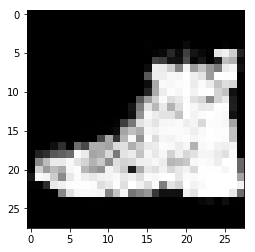

In [8]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()